### **Import required libraries**

In [ ]:

import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### **Visualize the Data with its Labels**

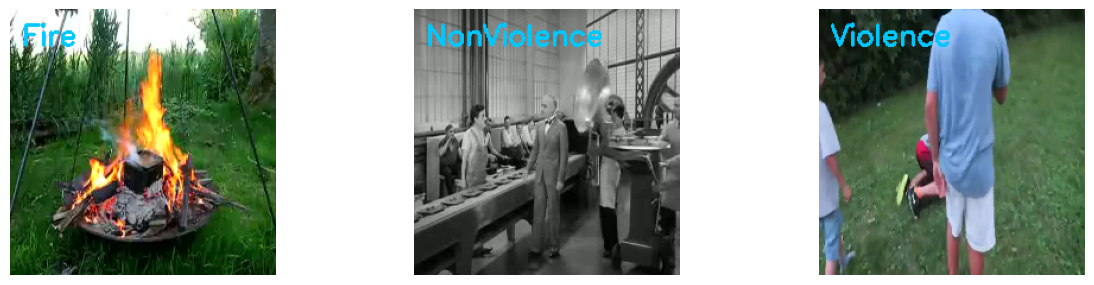

In [ ]:
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories 
all_classes_names = os.listdir('Dataset')

# Iterate through all the classes in the dataset.
for counter, class_name in enumerate(all_classes_names, 1):

    # Retrieve the list of all the video files present in the Class Directory.
    video_files_names_list = os.listdir(f'Dataset/{class_name}')

    # Randomly select a video file from the list retrieved from the Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/{class_name}/{selected_video_file_name}')
    
    # Check if the video reader is able to read the first frame of the video.
    if not video_reader.isOpened():
        print(f"Could not open video file: {selected_video_file_name}")
        continue
    
    # Read the first frame of the video file.
    ret, bgr_frame = video_reader.read()
    if not ret:
        print(f"Could not read frame from video file: {selected_video_file_name}")
        continue
    
    # Resize the frame.
    bgr_frame = cv2.resize(bgr_frame, (224, 224))

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')


In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing 
DATASET_DIR = r"C:\Users\bazil\Desktop\Project\Dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["NonViolence","Violence","Fire_smoke"]


### **Create a Function to Extract, Resize & Normalize Frames**

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

### **Function to create Dataset**

In [ ]:
'''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
'''


def create_dataset():
   
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence
Extracting Data of Class: Fire_smoke


In [ ]:
#  converting labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
print("Total number of videos in the training set:", len(features_train))
print("Total number of videos in the testing set:", len(features_test))

Total number of videos in the training set: 1535
Total number of videos in the testing set: 512


### **Creating LRCN Model**

In [ ]:

def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
307/307 [==============================] - 36s 104ms/step - loss: 0.8048 - accuracy: 0.4951 - val_loss: 0.7786 - val_accuracy: 0.4788
Epoch 2/50
307/307 [==============================] - 30s 97ms/step - loss: 0.7865 - accuracy: 0.5236 - val_loss: 0.7272 - val_accuracy: 0.6319
Epoch 3/50
307/307 [==============================] - 30s 97ms/step - loss: 0.7521 - accuracy: 0.5928 - val_loss: 0.6811 - val_accuracy: 0.6352
Epoch 4/50
307/307 [==============================] - 31s 100ms/step - loss: 0.6894 - accuracy: 0.6645 - val_loss: 0.6063 - val_accuracy: 0.7296
Epoch 5/50
307/307 [==============================] - 32s 104ms/step - loss: 0.6054 - accuracy: 0.7158 - val_loss: 0.5681 - val_accuracy: 0.7329
Epoch 6/50
307/307 [==============================] - 32s 104ms/step - loss: 0.5523 - accuracy: 0.7655 - val_loss: 0.5621 - val_accuracy: 0.7362
Epoch 7/50
307/307 [==============================] - 32s 105ms/step - loss: 0.5123 - accuracy: 0.7736 - val_loss: 0.5290 - val_accu

In [ ]:
from tensorflow.keras.models import save_model

# Save the model to disk
save_model(LRCN_model, 'LRCN_Model.h5')


In [ ]:
from keras.models import load_model

loaded_model = load_model('LRCN_Model.h5')
print(loaded_model)

In [ ]:
predictions = LRCN_model.predict(features_test)

16/16 [==============================] - 4s 208ms/step


### **Evaluate the trained model**

In [ ]:
model_evaluation_history = loaded_model.evaluate(features_test, labels_test)

16/16 [==============================] - 4s 212ms/step - loss: 0.3512 - accuracy: 0.8477


### **Predicting the Video**

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [ ]:
# Specifying video to be predicted
input_video_file_path = r"C:\Users\bazil\Desktop\Project\Dataset\Violence\V2.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)


1/1 [==============================] - 0s 37ms/step
Predicted: Violence
Confidence: 0.9925179481506348
